In [26]:
#| echo: false
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# Data Reading
mychi_original = pd.read_csv('../final_datasets/My_CHI._My_Future._Programs.csv')
online = mychi_original.loc[mychi_original['Meeting Type']=='online']
mychi_zip = pd.read_csv('../final_datasets/in_person_events_with_zip copy.csv')

# DataFrame with In-Person and Online Events, plus ZIP Codes
my_chi = pd.concat([mychi_zip, online])

# Filtered df with only programs with Min Age under 25
mcmf = my_chi.loc[my_chi['Min Age'] < 25]
mcmf = mcmf.drop_duplicates(subset=['Program ID'])   # This only took out 271 programs. 

## Data Cleaning: Age Variables

I focused on the distribution of My CHI. My Future. programs by Age. Below displays the relationship between the "Min Age" and "Max Age" variables before binning into discrete ranges, as these variables were originally continuous in form.

Before this, I already dropped duplicate programs by Program ID to get unique programs and filtered the dataset to only include youth programs, in which the minimum age is under 25 years old.

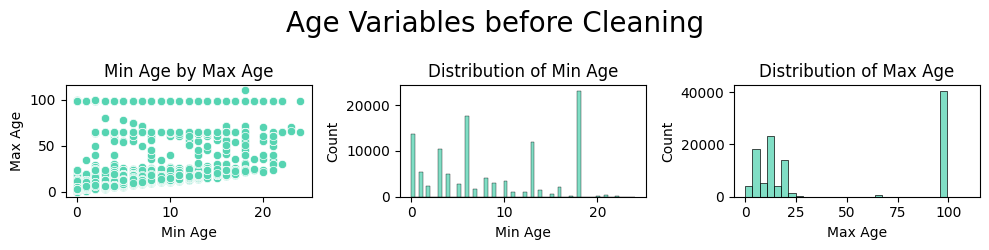

In [27]:
#| echo: false
fig, axes = plt.subplots(1, 3, figsize=(10,2.5))
plt.suptitle('Age Variables before Cleaning', size=20)
axes[0].set_title('Min Age by Max Age')
sns.scatterplot(data=mcmf, x='Min Age',  y='Max Age',  color='#56d4b2', ax=axes[0]);

axes[1].set_title('Distribution of Min Age')
sns.histplot(data=mcmf, x='Min Age', color='#56d4b2', ax=axes[1])

axes[2].set_title('Distribution of Max Age')
sns.histplot(data=mcmf, x='Max Age', color='#56d4b2', ax=axes[2])
plt.tight_layout()

From this quick EDA, we notice that the minimum age organizations have inputted (via My CHI. My Future's intake survey) range from 0-24. For the maximum age the range is even larger from 0-110. Visually we can see that there are abnormal clusters around age 0 and age 99.

There were 475 instances where both the minimum and maximum age were listed as 0 years old and there were 40,560 instances where the maximum age was listed as 99 or higher. 

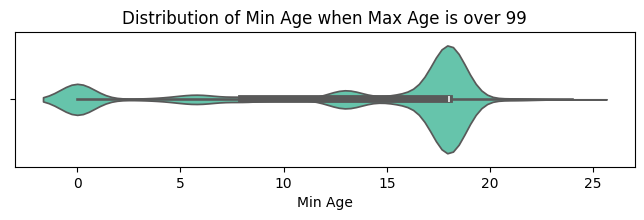

In [28]:
#| echo: false
# Subsets
no_age = mcmf.loc[(mcmf['Min Age'] == 0) & (mcmf['Max Age'] == 0)]
hundred_max = mcmf.loc[mcmf['Max Age'] >= 99]

# Plotting
plt.figure(figsize=(8,1.75))
sns.violinplot(data=hundred_max, x= 'Min Age', color='#56d4b2')
plt.title('Distribution of Min Age when Max Age is over 99');

From this information, I made two assumptions. For the programs in which the minimum and maximum ages were listed as 0, I assumed that these organizations were intending to communicate that they welcomed all ages to participate, and thus categorized them into family programs. However, when I discuss further implications of the current information intake survey given to these organizations by My CHI. My Future, I will further explain that this method likely has the opposite effect and causes their programs to be virtually invisible to community members. For the programs in which the maximum age is above 99, I assumed that these organizations meant to have no upper limit to the age of their particpants, and thus categorized these programs to being family focused programs, as per My CHI. My Future.'s specifications. 

### Analysis 3
*By Emerald Lewis*

## Further Data Preparation

Because age information for each program separately identified the minimum and maximum age, it was difficult to understand the target age ranges of programs in the My CHI. My Future. databast, further preventing meaningful data visualization on this topic. Thus, more data preparation was required. 

I binned the current continuous age representations into discrete bins of 
- Child: 0-4 years old  
- Elementary School: 5-11 years old
- Secondary School: 12-17 years old 
- Young Adult: 18-24 years old
- Family: Max Age over 25

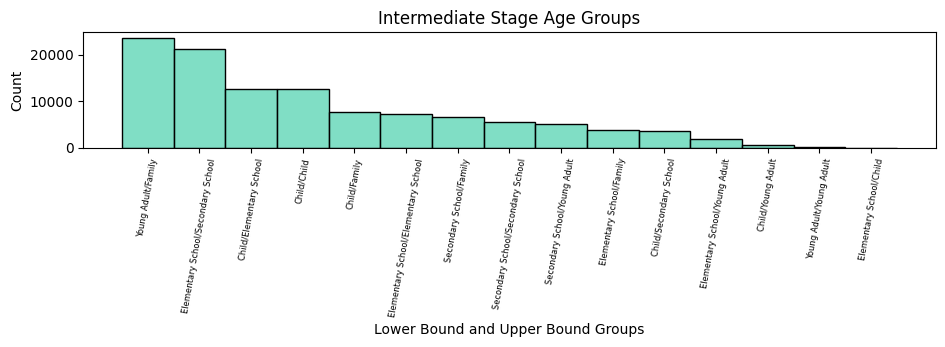

In [29]:
# | echo: false
mcmf['Group'] = np.nan
# 0's
no_age_index = no_age.index
mcmf.loc[no_age_index, 'Group'] = 'Family'  # Min/Max Age == 0
# max over 99
mcmf.loc[mcmf['Max Age'] >= 25, 'Group'] = 'Family'
bins = [-np.inf, 5, 12, 18, 25, mcmf['Max Age'].max()]
labels = ['Child', 'Elementary School', 'Secondary School', 'Young Adult', 'Family']
min_age_bins = pd.cut(mcmf['Min Age'], bins=bins, labels=labels, right=False)
max_age_bins = pd.cut(mcmf['Max Age'], bins=bins, labels=labels)

# str min/max
mcmf['Target Min'] = min_age_bins
mcmf['Target Max'] = max_age_bins

# combined age range
mcmf['Target Age'] = min_age_bins.astype(str)+'/'+max_age_bins.astype(str)
ta = ['Young Adult/Family', 'Elementary School/Secondary School', 'Child/Elementary School', 'Child/Child', 'Child/Family', 'Elementary School/Elementary School',
      'Secondary School/Family', 'Secondary School/Secondary School', 'Secondary School/Young Adult', 'Elementary School/Family', 'Child/Secondary School',
      'Elementary School/Young Adult', 'Child/Young Adult', 'Young Adult/Young Adult', 'Elementary School/Child']
mcmf['Target Age'] = pd.Categorical(mcmf['Target Age'], categories=ta, ordered=True)
plt.figure(figsize=(11, 1.5))
sns.histplot(mcmf, x= 'Target Age', color='#56d4b2')
plt.tick_params(axis='x', rotation= 80)
plt.title('Intermediate Stage Age Groups')
plt.xticks(fontsize=6)
plt.xlabel('Lower Bound and Upper Bound Groups');

However, these age groups are still not easy to understand, thus I decided to split programs into two different categories with different age bins in each.  
There were Narrow Age Range groups and Broad Age Range groups in which programs are mutually exclusive.  
For Narrow Age groups, these consisted of programs in which the minimum and maximum age fell within one group. For example, the programs in which their lower/upper bound groups were both Child, such as "Child/Child" with both the min-max age falling between 0-4 years old, shows a very clear target age group of just children from 0-4 years old, and thus are categorized accordingly.  
For Broad Age groups, these consisted of programs in which the minimum and maximum age fell across multiple groups. For example, there were 7602 programs in which the minimum age was somewhere between 0-4, and the maximum age was over 25. These programs were meant for both children and adults, "Child/Family", so I decided to include those programs in the Family group which covers the entire age range from the minimum and maximum ages of the entire dataset. 

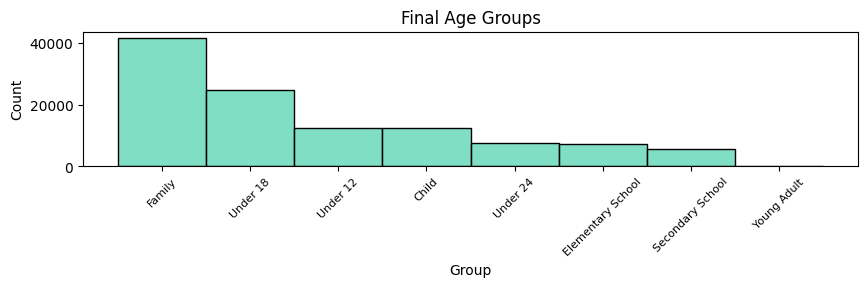

In [30]:
# | echo: false
# Function to help Categorize/Clean these Age Ranges
def categorize(row):
    if row['Target Min'] == row['Target Max']:
        return row['Target Min']                # Pure Category
    else:
        return row['Target Age']
    
mcmf['Group'] = mcmf.apply(categorize, axis=1)

# Adjust the larger Age Ranges to corresponde to Broader Categories
mcmf.loc[mcmf.Group.isin(['Young Adult/Family', 'Child/Family', 'Elementary School/Family', 'Secondary School/Family' ]), 'Group'] = 'Family'
mcmf.loc[mcmf.Group.isin(['Elementary School/Secondary School','Child/Secondary School']), 'Group'] = 'Under 18' # over 18
mcmf.loc[mcmf.Group.isin(['Child/Elementary School']), 'Group'] = 'Under 12' # under 18 years old
mcmf.loc[mcmf.Group.isin(['Secondary School/Young Adult', 'Elementary School/Young Adult', 'Child/Young Adult']), 'Group'] = 'Under 24'  # both minors and adults

# dropping 1 program in which it was only towards 5 year olds 
five_to_five = mcmf.loc[mcmf['Group'] == 'Elementary School/Child'].index.astype('int')
mcmf = mcmf.drop(five_to_five)

# plotting
g = ['Family', 'Under 18', 'Under 12', 'Child', 'Under 24', 'Elementary School', 'Secondary School', 'Young Adult']
mcmf['Group'] = pd.Categorical(mcmf['Group'], categories=g, ordered=True)
plt.figure(figsize=(10, 1.75))
sns.histplot(mcmf, x='Group', color='#56d4b2')
plt.tick_params(axis='x')
plt.xticks(fontsize=8, rotation= 45)
plt.title('Final Age Groups');

Now we can split this into the Narrow Age Ranges: Child, Elementary School, Secondary School, and Young Adult, and Broad Age Ranges: Under 12, Under 18, Under 24, and Family.

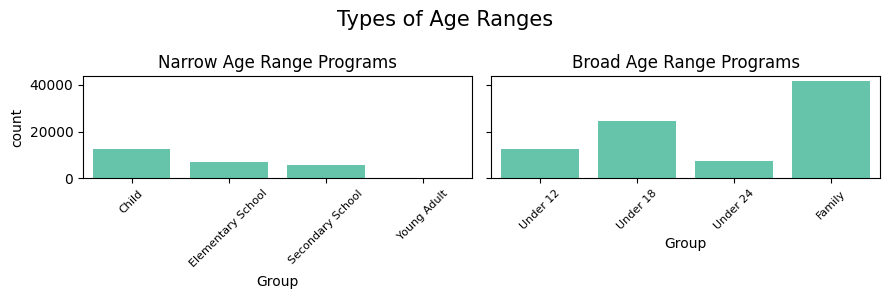

In [40]:
# | echo: false
# splitting data along the programs that target specific age ranges
narrow_groups = ['Child', 'Elementary School', 'Secondary School', 'Young Adult']
narrow_data = mcmf.loc[mcmf['Group'].isin(narrow_groups)]

# splitting data along the programs that target broad age ranges
broad_groups = ['Under 12', 'Under 18', 'Under 24', 'Family']
broad_data = mcmf.loc[mcmf['Group'].isin(broad_groups)]

# plotting
fig, axes = plt.subplots(1, 2, figsize=(9, 3), sharey=True)
plt.suptitle('Types of Age Ranges', fontsize=15)
narrow_data['Group'] = pd.Categorical(narrow_data['Group'], categories=narrow_groups, ordered=True)
axes[0].set_title('Narrow Age Range Programs')
axes[0].tick_params(axis='x', rotation=45)
sns.countplot(data=narrow_data, x='Group', color='#56d4b2', ax=axes[0])

broad_data['Group'] = pd.Categorical(broad_data['Group'], categories=broad_groups, ordered=True)
axes[1].set_title('Broad Age Range Programs')
axes[1].tick_params(axis='x', rotation=45)
sns.countplot(data=broad_data, x='Group', color='#56d4b2', ax=axes[1])
plt.xticks(fontsize=8)
for ax in axes.flat:
    ax.tick_params(axis='x', labelsize=8)
plt.tight_layout()

As seen in the multiple stages of data preparation into clear age groups, I had problems with coming up with the best way to represent the age groups of each program in a concise and clear manner. Realizing that programs often were split amongst very narrow age ranges or more broad age ranges helped in my analysis. 

I deemed this distinction necessary because if a 12 year old were to go to a program that was broadly geared towards anyone under 12, they might find themselves feeling out of place as the oldest participant. But if the same 12 year old went to a program meant for people under 18, they could be in the middle of the age range at the event, making them also feel uncomfortable. More seriously, if that 12 year old went to a program meant for anyone under 24, there is a possibility that both minors and adults are present, which could introduce new liabilities to the program leadership as parents may be uncomfortable with their 12 year old interacting with 24 year olds. Having many programs in which a very specific age group is being served, such as programs specifically meant for that 12 year old in which they would be surrounded by fellow elementary and/or secondary school aged students would be the best case scenario with the people in attendance sharing their stage of life with similar interests and maturity levels. 

## Recommendations to Stakeholders

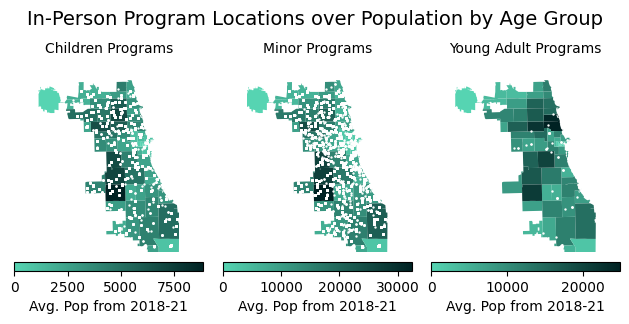

In [32]:
# | echo: false
import geopandas as gpd
import geopandas
import folium 
import geodatasets
from shapely.geometry import Point
from matplotlib.colors import LinearSegmentedColormap 
colors = ['#56d4b2', '#002223'] 
cmap = LinearSegmentedColormap.from_list("custom_cmap", colors) 

pop = pd.read_csv('../final_datasets/Chicago_Population_Counts_20241118.csv')
chicago = gpd.read_file(r'../final_datasets/geo_export_5fa10c19-68a4-4f1a-ad6e-0abb4091297b.shp')
pop_zip = pop.loc[pop['Geography Type'] == 'ZIP Code']
pop_by_zip = pop_zip.groupby(['Geography'])[['Population - Age 0-4', 'Population - Age 0-17', 'Population - Age 18-29']].mean()
population = pop_by_zip.reset_index()
population = population.rename(columns={'Geography': 'zip', 'Population - Age 0-4':'Age 0-4',  'Population - Age 0-17':'Age 0-17', 'Population - Age 18-29':'Age 18-29'})
chicago['zip'] = chicago['zip'].astype(str)
population['zip'] = population['zip'].astype(str)
chi_pop = chicago.merge(population, on= 'zip', how='left')

# plotting 
child_df = narrow_data.loc[narrow_data['Group'] =='Child']
child_df = child_df.drop(columns=child_df.columns.difference(['Longitude', 'Latitude']))
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax = plt.subplots(1, 3)
plt.suptitle('In-Person Program Locations over Population by Age Group', size=14, y=0.81)
# children
divider = make_axes_locatable(ax[0])
cax = divider.append_axes("bottom", size="5%", pad=0.1)
base = chi_pop.plot(column='Age 0-4', ax=ax[0], cmap=cmap, legend=True, cax=cax, legend_kwds={"label": "Avg. Pop from 2018-21", "orientation": "horizontal"}, zorder= 1)
ax[0].set_axis_off()
ax[0].set_title('Children Programs', fontsize=10, fontweight='light', pad=20)
# add scatterplot of in person events for Children ages 0-4
ax[0].scatter(child_df['Longitude'], child_df['Latitude'], s=0.5, color='white', marker='o', zorder=2);

# all minors
five_eleven = narrow_data.loc[(narrow_data['Group'] =='Elementary School') | (narrow_data['Group'] =='Secondary School')]
five_to_eleven = five_eleven.loc[:, ['Longitude', 'Latitude']]
minors_df = broad_data.loc[broad_data['Group'] =='Under 18']
minors_df = minors_df.loc[:, ['Longitude', 'Latitude']]
all_minors = pd.concat([five_to_eleven, minors_df])
divider = make_axes_locatable(ax[1])
cax = divider.append_axes("bottom", size="5%", pad=0.1)
base = chi_pop.plot(column='Age 0-17', ax=ax[1], cmap=cmap, legend=True, cax=cax, legend_kwds={"label": "Avg. Pop from 2018-21", "orientation": "horizontal"}, zorder= 1)
ax[1].set_axis_off()
ax[1].set_title('Minor Programs', fontsize=10, fontweight='light', pad=20)
# add scatterplot of in person events for Minors ages 0-17
ax[1].scatter(all_minors['Longitude'], all_minors['Latitude'], s=0.5, color='white', marker='o', zorder=2);

# young adults
ya = mcmf.loc[((mcmf['Min Age'] >=18) & (mcmf['Min Age'] < 30) & (mcmf['Max Age'] < 30) & (mcmf['Max Age'] >=18))]
ya = ya.loc[:, ['Longitude', 'Latitude']]
divider = make_axes_locatable(ax[2])
cax = divider.append_axes("bottom", size="5%", pad=0.1)
base = chi_pop.plot(column='Age 18-29', ax=ax[2], cmap=cmap, legend=True, cax=cax, legend_kwds={"label": "Avg. Pop from 2018-21", "orientation": "horizontal"}, zorder= 1)
ax[2].set_axis_off()
ax[2].set_title('Young Adult Programs', fontsize=10, fontweight='light', pad=20)
# add scatterplot of in person events for YA ages 18-29
ax[2].scatter(ya['Longitude'], ya['Latitude'], s=0.5, color='white', marker='o', zorder=2);

ax[0].set_xlim(chi_pop.total_bounds[0], chi_pop.total_bounds[2])
ax[0].set_ylim(chi_pop.total_bounds[1], chi_pop.total_bounds[3])
ax[1].set_xlim(chi_pop.total_bounds[0], chi_pop.total_bounds[2])
ax[1].set_ylim(chi_pop.total_bounds[1], chi_pop.total_bounds[3])
ax[2].set_xlim(chi_pop.total_bounds[0], chi_pop.total_bounds[2])
ax[2].set_ylim(chi_pop.total_bounds[1], chi_pop.total_bounds[3])
plt.tight_layout()

These plots show the ZIP Codes in which each age group is concentrated by darkness of color, with the in-person programs with location in white. There are 12,530 programs for Children ages 0-4 years old, 37,435 programs for Minors under 18 years old, and 83 programs for Young Adults aged 18-24. 

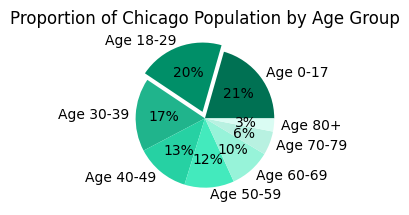

In [33]:
# | echo: false
labels = ['Age 0-17', 'Age 18-29', 'Age 30-39', 'Age 40-49', 'Age 50-59', 'Age 60-69', 'Age 70-79', 'Age 80+']
colors = ['#007153', '#008F68', '#20B48C', '#26D1A3', '#43EABD', '#97F3D9', '#B8F1E1', '#DAFCF3']
explode = [0, 0.1, 0, 0, 0, 0, 0, 0]
pie_pop = pop.groupby(['Geography'])[['Population - Age 0-17', 'Population - Age 18-29',
                                     'Population - Age 30-39', 'Population - Age 40-49',
                                   'Population - Age 50-59', 'Population - Age 60-69',
                                    'Population - Age 70-79', 'Population - Age 80+']].mean().sum()
plt.figure(figsize=(2.25, 2.25))
plt.pie(pie_pop, labels=labels, colors=colors, explode=explode, autopct='%.0f%%')
plt.title('Proportion of Chicago Population by Age Group');

There are incredibly few programs for Young Adults in Chicago, despite the fact that they make up 20% of Chicago's population. According to *On Edge: Understanding and Preventing Young Adults' Mental Health Challenges*, Harvard Graduate Students state that "as a society we’ve done little to support emerging adults at precisely the time when they are dealing with the most defining, stressful decisions of their lives related to work, love, and identity. Who to love? What to be? There are fundamental problems with the ways we’ve structured the passage to adulthood in this country, including that young adults often don’t have easy access to supportive communities." **Citation https://static1.squarespace.com/static/5b7c56e255b02c683659fe43/t/6537db8894f0802b6480d38e/1698159503140/On+Edge_FINAL.pdf page 7** 

If My CHI. My Future. were to pay close attention and provide multitudes of programs for the young adults of Chicago who could be starting out their careers and adult lives by themselves for the first time and finding themselves unsure of themselvs and struggling, perhaps these questions about how to live and how to love could be answered by mentors and community members that truly care. 

## Further recommendations to stakeholder(s)


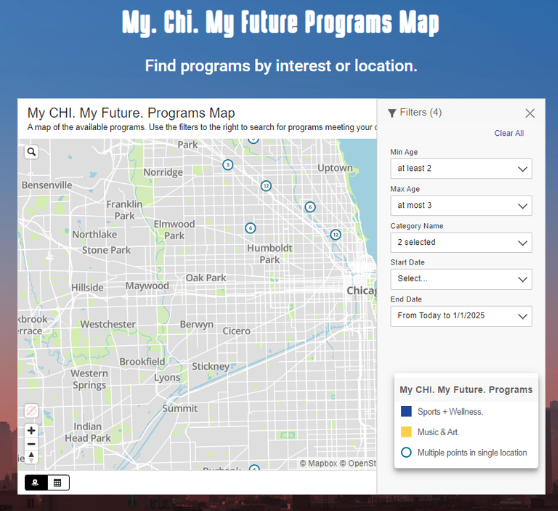

In [34]:
# | echo: false
from IPython.display import Image
Image('C:/Users/emera/Documents/STAT303/STAT303-1/final_project/image.png', width=300, height=300)

While continuous minimum and maximum age is helpful for students and families to search for programs that best fit their age group needs, the current system of searching by minimum and maximum age could also inadvertently cause those previously mentioned programs, with minimum age and maximum age of 0 perhaps intending to not put an age bound on ftheir programs, to perhaps never show up as an option through this method of searching by age.  

Thus, I would suggest an addition of a variable that holds the target age range for each program to improve data manipulation and visualization for future analysts as well as clarify what target age range each program is intending to serve, allowing the best representation of programs by age both internally and externally if My CHI. My Future. were to change their current search system. 

# Limitations

In my analysis, I separated programs into mutally exclusive categories of Narrow Age Ranges and Broad Age Ranges, however, My CHI. My Future can also decide to make these programs mutually inclusive to serve their analysis if they so choose. This would mean that a program that is meant for 0-99 year olds would be able to be found when a search query for programs for 2-5 year olds is done. There are benefits to this system as programs would have more exposure and could help families find programs for their specific children's ages, however in my analysis I chose to keep programs mutually exclusive due to reasons stated above. 